There are three data sets of OBIEE usage data, one for each month April, May and June of 2019. The structure of the file is given below.

Input:

One file per month. Each record represents a user query. Queries are gropued into sessions identified by a session ID. 

Data elements:

* User - email address of OBIEE user 

* User Campus - campus identifier of OBIEE user, "wisc" = UW Madison 

* BI Presentation Catalog - top of reporting hierarchy, for example, "UWHRS Workforce" 

* Logical Query Submit Timestamp - Start of query 

* Logical Query Complete Timestamp - End of query 

* DB Row Return - number of database rows returned 

* Query Rows Returned - number of RPD rows returned 

* Total BI Response (Sec) - number of seconds to process BI request 

* BI Path - path to BI report element, for example, "/shared/UWSYS - Shared/UWHRS - Shared/UWHRS - Payroll Reports/UWRS - Employee Hours and EarningsAnalysis/EMployee Hours and Earnings" 

    The 4th element is the Catalog 
    The 5th element is the Dashboard 
* Session ID - identifier of a particular sequence of interactions, typically with a specific dashboard 

* Query Text - SQL query text

Output: 

User Report 

* Month, User, # unique dashboards, # sessions, # queries, total time, average queries per session, avg time per session 

Dashboard Report 

* Month, Dashboard, # unique users, # sessions, # queries, total time, average queries per session, average time per session 

User/Dashboard Report 

* Month, User, Catalog, Dashboard, # sessions, # queries, total time, average queries per session, avg time per session 

1.  Compute monthly grand totals for total time and number of queries in both the per user data set and the per dashboard data set.  Compare the grand totals.  They should be equal.  If they're not equal, please treat this as a bug.  Determine why they're not and implement a fix to ensure that they are equal.

 

2.  Compute additional averages for the dashboard tables:  avg time per unique user, avg queries per unique user, avg sessions per unique user

 

3.  Develop two scatterplots for the dashboard data set. 

              3a.  X axis: Total Time.  Y axis: Number of queries.   Scale the size of the points to the number of sessions. 

              3b.  X axis: base 10 log(Total Time),  Y axis: base 10 log( Number of queries).  Scale the size of the points to the number of sessions. 

In [1]:
# import python modules and libraries 
import os 
import sys 
import importlib
import os.path
import xlsxwriter
import cte 
import openpyxl
import ctedefs
import datetime as dt
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from pathlib import Path 
from sqlalchemy import create_engine 
from pandas import read_excel

In [2]:
project_dir = os.path.abspath('') # find the project directory
timestamp = dt.datetime.now().strftime("%Y%m%d%H%M%S")
userprofile_dir = Path(os.environ['USERPROFILE']) # environment var 
connection_module = 'connection' # connection.py in the home dir 

In [3]:
# Run data processing scripts to turn raw data from (.../raw) into cleaned data 
# ready to be analyzed (saved in the current directory).
sys.path.append(str(userprofile_dir)) # find module 
connection = importlib.import_module(connection_module) # dynamically import connection.py as module 
sys.path.remove(str(userprofile_dir))

engine = create_engine(connection.epm()) # epm() function in connection module, create a connection string
con = engine.connect() # connect 

In [4]:
userprofile_dir

WindowsPath('C:/Users/sliu')

In [5]:
# random testing 1 
df = pd.read_sql('select 1 as cnt from dual', con)
if (df['cnt'][0] == 1):
    result = 'success'
else:
    result = 'failure'
print(result)

success


## CSV data

### xlsx files
* OBIEE_USAGE_DETAIL_201904
* OBIEE_USAGE_DETAIL_201905
* OBIEE_USAGE_DETAIL_201906

In [6]:
# Read an Excel table into a pandas Dataframe 
df1_04 = pd.read_excel("OBIEE_USAGE_DETAIL_201904.xlsx")
df2_05 = pd.read_excel("OBIEE_USAGE_DETAIL_201905.xlsx")
df3_06 = pd.read_excel("OBIEE_USAGE_DETAIL_201906.xlsx")

In [7]:
df1_04.columns

Index(['User', 'User Campus', 'BI Presentation Catalog',
       'Logical Query Submit Timestamp', 'Logical Query Complete Timestamp',
       'DB Row Return', 'Query Rows Returned', 'Total BI Response (sec)',
       'BI Path', 'SESSION_ID', 'Query Text'],
      dtype='object')

### User Report 

Element: Month, User, # unique dashboards, # sessions, # queries, total time, average queries per session, avg time per session 

* Month: Get from "Logical Query Submit/Complete Timestamp" column (Start date of the month)


* User: Get from "User" column


* number of unique dashboards: Get from "BI path" column, /shared/UWSYS - Shared/UWHRS - Shared/UWHRS - Compensation Reports/UWHRS - Salary Equity/Analyses/Salary Statistics Overview (UWHRS-Salary Equity)


* number of sessions: number of unique SESSION_ID per user 


* number of queries: Get from "DB Row Return" column, add up the columns for each individual user 


* total time: Total BI Response (sec) per user 


* Average queries per session: # queries / # sessions 


* avg time per session: # sessions / total time 

#### OBIEE_USAGE_DETAIL_201904.xlsx

In [8]:
df1_04 = df1_04.drop('Query Text', 1)
df1_04 = df1_04.drop('Logical Query Complete Timestamp', 1)

In [9]:
# change the column to month 
df1_04['Logical Query Submit Timestamp'] = df1_04['Logical Query Submit Timestamp'].apply(lambda x: "04/01")
df1_04 = df1_04.rename(columns={"Logical Query Submit Timestamp": "Month"})

In [10]:
# Testing for the column's names 
df1_04.columns

Index(['User', 'User Campus', 'BI Presentation Catalog', 'Month',
       'DB Row Return', 'Query Rows Returned', 'Total BI Response (sec)',
       'BI Path', 'SESSION_ID'],
      dtype='object')

In [11]:
# group by User
# Number of unique dashboards 
# Number of sessions 
# Number of queries 
# Total time 

# Total time per unique user 
df_total_time = df1_04.groupby("User")['Total BI Response (sec)'].sum()

In [12]:
# Number of sessions: # of unique SESSION_ID per user 
df_num_sessions = df1_04.groupby("User").SESSION_ID.nunique()

In [13]:
# Number of queries: "DB Row Return" column, add up the rows for each user 
df_num_queries = df1_04.groupby("User")['DB Row Return'].sum()

In [14]:
# Number of unique dashboards
df_new = df1_04[df1_04['BI Path'].notnull()]

In [15]:
# Manipulate the column 'BI Path' to prep for the count 
pd.options.mode.chained_assignment = None  # default='warn'
df_new['BI Path'] = df_new['BI Path'].apply(lambda x: x.split('/')[5] if len(x.split('/')) > 5 else "unspecified")

In [16]:
# Count the number of unique dashboards
df_num_unique_dashboard = df_new.groupby("User")['BI Path'].nunique()

In [17]:
# Manipulate the original dataframe, reduce the rows to one row per unique user 
df1_04 = df1_04.drop_duplicates(subset=['User'])

In [18]:
df1_04 = pd.merge(df1_04, df_total_time, on=['User'])
df1_04 = pd.merge(df1_04,  df_num_queries, on=['User'])
df1_04 = pd.merge(df1_04,  df_num_sessions, on=['User'])
df1_04 = pd.merge(df1_04,  df_num_unique_dashboard, on=['User'])
df1_04.columns

Index(['User', 'User Campus', 'BI Presentation Catalog', 'Month',
       'DB Row Return_x', 'Query Rows Returned', 'Total BI Response (sec)_x',
       'BI Path_x', 'SESSION_ID_x', 'Total BI Response (sec)_y',
       'DB Row Return_y', 'SESSION_ID_y', 'BI Path_y'],
      dtype='object')

In [19]:
df1_04 = df1_04.drop('User Campus', 1)
df1_04 = df1_04.drop('BI Presentation Catalog', 1)
df1_04 = df1_04.drop('BI Path_x', 1)
df1_04 = df1_04.drop('SESSION_ID_x', 1)
df1_04 = df1_04.drop('Query Rows Returned', 1)
df1_04 = df1_04.drop('DB Row Return_x',1)
df1_04 = df1_04.drop('Total BI Response (sec)_x',1)

In [20]:
# rename the column, and calculating the average queries per session and average time per session 
df1_04.rename(columns={'Total BI Response (sec)_y':'Total Time',
                          'DB Row Return_y':'Number of queries',
                          'SESSION_ID_y':'Number of sessions',
                          'BI Path_y': 'Number of unique dashboards'}, 
                 inplace=True)

In [21]:
# Average queries per session: number of queries / number of sessions 
# avg time per session: number of sessions / total time 
df1_04['Avg queries per session'] = df1_04['Number of queries'] / df1_04['Number of sessions']
df1_04['Avg time per session'] = df1_04['Total Time'] / df1_04['Number of sessions'] 

In [22]:
df1_04 = df1_04.round({'Avg queries per session': 2, 'Avg time per session': 2})
df = df1_04.replace([np.inf, -np.inf], np.nan)
df

User  Month  Total Time  Number of queries  \
0        aaarnold@wisc.edu  04/01        2777              13640   
1       abradshaw@wisc.edu  04/01        1358             115285   
2       ackinney2@wisc.edu  04/01        9707             137222   
3        acmalone@wisc.edu  04/01       13282             297974   
4        admeyer3@wisc.edu  04/01         467               6922   
5        adstern2@wisc.edu  04/01        8851             579625   
6    aebartholome@wisc.edu  04/01        5190             357491   
7      aeschuster@wisc.edu  04/01        1387               3997   
8       afherrick@wisc.edu  04/01        1921               9993   
9        ahedding@wisc.edu  04/01          85               2599   
10        ahering@wisc.edu  04/01       24050              60943   
11       ajluckey@wisc.edu  04/01           7               6087   
12        ajrosas@wisc.edu  04/01         419             448428   
13      ajschulz2@wisc.edu  04/01         108               6395   
14    alcartagena@wisc.edu  04/01       17422             363030   
15         allaby@wisc.edu  04/01        1554              37355   
16         amenda@wisc.edu  04/01         470               8603   
17         amlund@wisc.edu  04/01       15353            2789694   
18     ammekschun@wisc.edu  04/01        1408            2182919   
19    ammurphylom@wisc.edu  04/01        2714             173366   
20   amoslandgraf@wisc.edu  04/01        1097               4745   
21     amwebster4@wisc.edu  04/01          63             109481   
22       anderle2@wisc.edu  04/01         295              99485   
23       anlefkow@wisc.edu  04/01         439              67699   
24      areierson@wisc.edu  04/01        4013               5332   
25   arichardson2@wisc.edu  04/01         921              13475   
26       arturner@wisc.edu  04/01        4625             165832   
27        atamayo@wisc.edu  04/01        1324               7794   
28         athnos@wisc.edu  04/01         923             459854   
29     awoodward2@wisc.edu  04/01        2191              25719   
..                     ...    ...         ...                ...   
293        tflock@wisc.edu  04/01        2272               4640   
294       therbst@wisc.edu  04/01          97             105226   
295       thuecks@wisc.edu  04/01        3153             117319   
296       timbers@wisc.edu  04/01          19               8463   
297       tlbauer@wisc.edu  04/01         321            2140798   
298       tlcheck@wisc.edu  04/01           1                 11   
299      tlehmann@wisc.edu  04/01          88             187415   
300        tmanke@wisc.edu  04/01        5754            3128006   
301      tneisius@wisc.edu  04/01         182              10817   
302       tnewell@wisc.edu  04/01        3258               7986   
303      tpetrick@wisc.edu  04/01         250              54613   
304        tschry@wisc.edu  04/01        5447              21465   
305      tspitzig@wisc.edu  04/01         859             365407   
306     tssanders@wisc.edu  04/01        3910               9931   
307        tstarr@wisc.edu  04/01         670             175046   
308      twipperf@wisc.edu  04/01         183              43923   
309         uhlir@wisc.edu  04/01       11402             519206   
310    valentine3@wisc.edu  04/01         467            2131151   
311     varneson2@wisc.edu  04/01        2402             106368   
312         vaudt@wisc.edu  04/01         228              92752   
313       verhage@wisc.edu  04/01          83              11704   
314       vfugate@wisc.edu  04/01        8040             191257   
315       vlkelly@wisc.edu  04/01        8902             659469   
316      vpierce2@wisc.edu  04/01         946             163431   
317       vtimler@wisc.edu  04/01         138              75517   
318        vvosen@wisc.edu  04/01        1566              18493   
319    wbollinger@wisc.edu  04/01           0                 13   
320       

In [23]:
# calculating the sum of the total time 
df['Total Time'].sum()

1052081

In [24]:
# calculating the sum of the number of queries 
df['Number of queries'].sum()

128623494

#### OBIEE_USAGE_DETAIL_201905.xlsx

In [25]:
df2_05 = df2_05.drop('Query Text', 1)
df2_05 = df2_05.drop('Logical Query Complete Timestamp', 1)

# change the column to month 
df2_05['Logical Query Submit Timestamp'] = df2_05['Logical Query Submit Timestamp'].apply(lambda x: "05/01")
df2_05 = df2_05.rename(columns={"Logical Query Submit Timestamp": "Month"})

# group by User
# Number of unique dashboards 
# Number of sessions 
# Number of queries 
# Total time 

# Total time per unique user 
df_total_time = df2_05.groupby("User")['Total BI Response (sec)'].sum()

# Number of sessions: # of unique SESSION_ID per user 
df_num_sessions = df2_05.groupby("User").SESSION_ID.nunique()

# Number of queries: "DB Row Return" column, add up the rows for each user 
df_num_queries = df2_05.groupby("User")['DB Row Return'].sum()

# Number of unique dashboards
df_new = df2_05[df2_05['BI Path'].notnull()]

# Manipulate the column 'BI Path' to prep for the count 
df_new['BI Path'] = df_new['BI Path'].apply(lambda x: x.split('/')[5] if len(x.split('/')) > 5 else "unspecified")
# Count the number of unique dashboards
df_num_unique_dashboard = df_new.groupby("User")['BI Path'].nunique()

# Manipulate the original dataframe, reduce the rows to one row per unique user 
df2_05 = df2_05.drop_duplicates(subset=['User'])

df2_05 = pd.merge(df2_05, df_total_time, on=['User'])
df2_05 = pd.merge(df2_05,  df_num_queries, on=['User'])
df2_05 = pd.merge(df2_05,  df_num_sessions, on=['User'])
df2_05 = pd.merge(df2_05,  df_num_unique_dashboard, on=['User'])

df2_05 = df2_05.drop('User Campus', 1)
df2_05 = df2_05.drop('BI Presentation Catalog', 1)
df2_05 = df2_05.drop('BI Path_x', 1)
df2_05 = df2_05.drop('SESSION_ID_x', 1)
df2_05 = df2_05.drop('Query Rows Returned', 1)
df2_05 = df2_05.drop('DB Row Return_x',1)
df2_05 = df2_05.drop('Total BI Response (sec)_x',1)

# rename the column, and calculating the average queries per session and average time per session 
df2_05.rename(columns={'Total BI Response (sec)_y':'Total Time',
                          'DB Row Return_y':'Number of queries',
                          'SESSION_ID_y':'Number of sessions',
                          'BI Path_y': 'Number of unique dashboards'}, 
                 inplace=True)

# Average queries per session: number of queries / number of sessions 
# avg time per session: number of sessions / total time 
df2_05['Avg queries per session'] = df2_05['Number of queries'] / df2_05['Number of sessions']
df2_05['Avg time per session'] =  df2_05['Total Time'] / df2_05['Number of sessions'] 

df2_05 = df2_05.round({'Avg queries per session': 2, 'Avg time per session': 2})
df = df2_05.replace([np.inf, -np.inf], np.nan)
df

User  Month  Total Time  Number of queries  \
0        aaarnold@wisc.edu  05/01        1080              29970   
1         aahearn@wisc.edu  05/01         240               3457   
2       abradshaw@wisc.edu  05/01        1093               1512   
3       ackinney2@wisc.edu  05/01       27951             220508   
4        acmalone@wisc.edu  05/01       38310             540054   
5        admeyer3@wisc.edu  05/01         344               1109   
6        adstern2@wisc.edu  05/01          55                184   
7    aebartholome@wisc.edu  05/01        6952             573660   
8      aeschuster@wisc.edu  05/01        3110              22893   
9       afherrick@wisc.edu  05/01        1322              10675   
10       ahedding@wisc.edu  05/01        5138             146419   
11        ahering@wisc.edu  05/01       11342              10349   
12     ajohnson33@wisc.edu  05/01          24               1099   
13        ajrosas@wisc.edu  05/01        5979            1278605   
14      ajschulz2@wisc.edu  05/01        1394              15711   
15    alcartagena@wisc.edu  05/01       14310              24193   
16         allaby@wisc.edu  05/01        7884            2206295   
17         amenda@wisc.edu  05/01         575              27427   
18         amlund@wisc.edu  05/01       18208            2400188   
19     ammekschun@wisc.edu  05/01        4220               5410   
20    ammurphylom@wisc.edu  05/01        1325             578176   
21     amueller26@wisc.edu  05/01           4               3774   
22     amwebster4@wisc.edu  05/01           5                657   
23       anderle2@wisc.edu  05/01           2                220   
24       anlefkow@wisc.edu  05/01           2              28361   
25      areierson@wisc.edu  05/01         109              89242   
26   arichardson2@wisc.edu  05/01        2793              12178   
27       arturner@wisc.edu  05/01        3485             148136   
28        atamayo@wisc.edu  05/01        2106               6440   
29         athnos@wisc.edu  05/01         772             309127   
..                     ...    ...         ...                ...   
311       tlcheck@wisc.edu  05/01         370               2834   
312      tlehmann@wisc.edu  05/01         101             187224   
313     tlsimpson@wisc.edu  05/01        3176               7930   
314        tmanke@wisc.edu  05/01        3508              21472   
315       tnewell@wisc.edu  05/01          19               1897   
316      tpetrick@wisc.edu  05/01         352              13351   
317        tschry@wisc.edu  05/01        6480              55739   
318      tspitzig@wisc.edu  05/01          61               2330   
319     tssanders@wisc.edu  05/01         363            2144256   
320        tstarr@wisc.edu  05/01        4221            2171555   
321        turino@wisc.edu  05/01          15               1921   
322      twipperf@wisc.edu  05/01        2240            4612270   
323         uhlir@wisc.edu  05/01        8040              62102   
324       ullsvik@wisc.edu  05/01          61             153154   
325        ushman@wisc.edu  05/01         713              88453   
326    valentine3@wisc.edu  05/01         184              40127   
327     varneson2@wisc.edu  05/01        1027             165965   
328         vaudt@wisc.edu  05/01          19              13365   
329       verhage@wisc.edu  05/01          90              90818   
330       vfugate@wisc.edu  05/01        1809              39347   
331       vlkelly@wisc.edu  05/01        5575            2254231   
332      vpierce2@wisc.edu  05/01        7778             144755   
333       vtimler@wisc.edu  05/01        8486            2150578   
334        vvosen@wisc.edu  05/01        4079             120515   
335    wbollinger@wisc.edu  05/01        4019            2772698   
336        wemett@wisc.edu  05/01       10535            2210875   
337       whetter@wisc.edu  05/01          24                 79   
338       

In [26]:
# calculating the sum of the total time 
df['Total Time'].sum()

1147676

In [27]:
# calculating the sum of the number of queries 
df['Number of queries'].sum()

275371693

#### OBIEE_USAGE_DETAIL_201906.xlsx

In [28]:
df3_06 = df3_06.drop('Query Text', 1)
df3_06 = df3_06.drop('Logical Query Complete Timestamp', 1)

# change the column to month 
df3_06['Logical Query Submit Timestamp'] = df3_06['Logical Query Submit Timestamp'].apply(lambda x: "06/01")
df3_06 = df3_06.rename(columns={"Logical Query Submit Timestamp": "Month"})

# group by User
# Number of unique dashboards 
# Number of sessions 
# Number of queries 
# Total time 

# Total time per unique user 
df_total_time = df3_06.groupby("User")['Total BI Response (sec)'].sum()

# Number of sessions: # of unique SESSION_ID per user 
df_num_sessions = df3_06.groupby("User").SESSION_ID.nunique()

# Number of queries: "DB Row Return" column, add up the rows for each user 
df_num_queries = df3_06.groupby("User")['DB Row Return'].sum()

# Number of unique dashboards
df_new = df3_06[df3_06['BI Path'].notnull()]

# Manipulate the column 'BI Path' to prep for the count 
df_new['BI Path'] = df_new['BI Path'].apply(lambda x: x.split('/')[5] if len(x.split('/')) > 5 else "unspecified")
# Count the number of unique dashboards
df_num_unique_dashboard = df_new.groupby("User")['BI Path'].nunique()

# Manipulate the original dataframe, reduce the rows to one row per unique user 
df3_06 = df3_06.drop_duplicates(subset=['User'])

df3_06 = pd.merge(df3_06, df_total_time, on=['User'])
df3_06 = pd.merge(df3_06,  df_num_queries, on=['User'])
df3_06 = pd.merge(df3_06,  df_num_sessions, on=['User'])
df3_06 = pd.merge(df3_06,  df_num_unique_dashboard, on=['User'])

# drop the columns that we don't want 
df3_06 = df3_06.drop('User Campus', 1)
df3_06 = df3_06.drop('BI Presentation Catalog', 1)
df3_06 = df3_06.drop('BI Path_x', 1)
df3_06 = df3_06.drop('SESSION_ID_x', 1)
df3_06 = df3_06.drop('Query Rows Returned', 1)
df3_06 = df3_06.drop('DB Row Return_x',1)
df3_06 = df3_06.drop('Total BI Response (sec)_x',1)

# rename the column, and calculating the average queries per session and average time per session 
df3_06.rename(columns={'Total BI Response (sec)_y':'Total Time',
                          'DB Row Return_y':'Number of queries',
                          'SESSION_ID_y':'Number of sessions',
                          'BI Path_y': 'Number of unique dashboards'}, 
                 inplace=True)


df3_06 = df3_06.round({'Avg queries per session': 2, 'Avg time per session': 2})
df = df3_06.replace([np.inf], np.nan)
df

User  Month  Total Time  Number of queries  \
0        aaarnold@wisc.edu  06/01         357               4871   
1       abradshaw@wisc.edu  06/01        6161             211721   
2       ackinney2@wisc.edu  06/01       17970             258461   
3        acmalone@wisc.edu  06/01       27977             643373   
4        admeyer3@wisc.edu  06/01         130               3040   
5    aebartholome@wisc.edu  06/01       12527            1067639   
6      aeschuster@wisc.edu  06/01          94               3493   
7       afherrick@wisc.edu  06/01         151              98058   
8        ahedding@wisc.edu  06/01         489              11344   
9         ahering@wisc.edu  06/01        3468             159094   
10       ajluckey@wisc.edu  06/01           6               2386   
11        ajrosas@wisc.edu  06/01        1798             923164   
12      ajschulz2@wisc.edu  06/01         172            2154609   
13    alcartagena@wisc.edu  06/01          23               1639   
14         allaby@wisc.edu  06/01         581             147834   
15         amenda@wisc.edu  06/01         504            2155434   
16         amlund@wisc.edu  06/01        6149             140053   
17     ammekschun@wisc.edu  06/01           0               2277   
18    ammurphylom@wisc.edu  06/01        6764              19971   
19   amoslandgraf@wisc.edu  06/01         133               2877   
20     amwebster4@wisc.edu  06/01           7                542   
21       anderle2@wisc.edu  06/01         467             122665   
22        aostrow@wisc.edu  06/01        4138               8407   
23      areierson@wisc.edu  06/01         303              24805   
24   arichardson2@wisc.edu  06/01         634              69114   
25       arturner@wisc.edu  06/01         535              12611   
26        atamayo@wisc.edu  06/01        2563                804   
27   avilarendero@wisc.edu  06/01         342             266195   
28     awoodward2@wisc.edu  06/01         273              24958   
29         azenke@wisc.edu  06/01         237             259076   
..                     ...    ...         ...                ...   
309       tlbauer@wisc.edu  06/01         976             115014   
310      tlbonner@wisc.edu  06/01           4               7396   
311      tlehmann@wisc.edu  06/01         184             600650   
312     tlsimpson@wisc.edu  06/01          67              69944   
313        tmanke@wisc.edu  06/01        1227            2233298   
314      tneisius@wisc.edu  06/01          16                927   
315       tnewell@wisc.edu  06/01        2061               2030   
316      tpetrick@wisc.edu  06/01         319              72204   
317        tschry@wisc.edu  06/01        3157              83211   
318      tspitzig@wisc.edu  06/01           5                384   
319     tssanders@wisc.edu  06/01         900              68862   
320        tstarr@wisc.edu  06/01         286            2192574   
321      twipperf@wisc.edu  06/01         993            6905027   
322         uhlir@wisc.edu  06/01        5725             185755   
323       ullsvik@wisc.edu  06/01         780            1757092   
324    valentine3@wisc.edu  06/01          26              11617   
325     varneson2@wisc.edu  06/01       11617            2266424   
326       verhage@wisc.edu  06/01        3858            4548656   
327       vfugate@wisc.edu  06/01       17642             856392   
328     vjackson3@wisc.edu  06/01         806               3519   
329       vlkelly@wisc.edu  06/01         895             665938   
330       vootkur@wisc.edu  06/01          13                606   
331      vpierce2@wisc.edu  06/01           2               1929   
332       vtimler@wisc.edu  06/01         345              28462   
333        vvosen@wisc.edu  06/01        1426            2230302   
334    wbollinger@wisc.edu  06/01        3485             122080   
335        wemett@wisc.edu  06/01        1244            4326076   
336       

In [29]:
# calculating the sum of the total time 
df['Total Time'].sum()

785793

In [30]:
# calculating the sum of the number of queries 
df['Number of queries'].sum()

-2752054873

### Dashboard Report 

Element: Month, Dashboard, # unique users, # sessions, # queries, total time, average queries per session, average time per session 

* Month: Get from "Logical Query Submit/Complete Timestamp" column (Start date of the month)


* Dashboard: Get from "BI path" column. The fifth element. If there's no fifth element, leave it as "unspecified". Blank is left as blank. 

Example: /shared/UWSYS - Shared/UWHRS - Shared/UWHRS - Compensation Reports/UWHRS - Salary Equity/Analyses/Salary Statistics Overview (UWHRS-Salary Equity)

* number of unique users: for each individual dashboard, find out the # of unique users per dashboard 


* number of sessions: number of unique SESSION_ID per dashboard 


* number of queries: Get from "DB Row Return" column, add up the columns for each individual dashboard 


* total time: Total BI Response (sec) per dashboard 


* Average queries per session: # of queries / # of sessions 


* avg time per session: # of sessions / total time 

In [31]:
# Read the Excel table again into pandas Dataframes 
df1_04 = pd.read_excel("OBIEE_USAGE_DETAIL_201904.xlsx")
df2_05 = pd.read_excel("OBIEE_USAGE_DETAIL_201905.xlsx")
df3_06 = pd.read_excel("OBIEE_USAGE_DETAIL_201906.xlsx")

#### OBIEE_USAGE_DETAIL_201904.xlsx

In [32]:
df1_04 = df1_04.drop('Query Text', 1)
df1_04 = df1_04.drop('Logical Query Complete Timestamp', 1)

In [33]:
# change the column to month 
df1_04['Logical Query Submit Timestamp'] = df1_04['Logical Query Submit Timestamp'].apply(lambda x: "04/01")
df1_04 = df1_04.rename(columns={"Logical Query Submit Timestamp": "Month"})

In [34]:
# Number of unique users

df1_04['BI Path'] = df1_04['BI Path'].fillna("")
df1_04['Dashboard'] = df1_04['BI Path'].apply(lambda x: x.split('/')[5] if len(x.split('/')) > 5 else "unspecified")

# Count the number of unique dashboards
df_num_unique_dashboard = df1_04.groupby("Dashboard")['User'].nunique()

pd.options.mode.chained_assignment = None  # default='warn'

In [35]:
# Number of sessions: # of unique SESSION_ID per unique dashboard 
df_num_sessions = df1_04.groupby("Dashboard").SESSION_ID.nunique()

In [36]:
# Number of queries: "DB Row Return" column, add up the rows for each dashboard 
df_num_queries = df1_04.groupby("Dashboard")['DB Row Return'].sum()

In [37]:
# Total Time 
df_total_time = df1_04.groupby("Dashboard")['Total BI Response (sec)'].sum()

In [38]:
# Manipulate the original dataframe, reduce the rows to one row per unique dashboard 
df1_04  = df1_04.drop_duplicates(subset=['Dashboard'])

In [39]:
df1_04 = pd.merge(df1_04, df_total_time, on=['Dashboard'])
df1_04 = pd.merge(df1_04,  df_num_queries, on=['Dashboard'])
df1_04 = pd.merge(df1_04,  df_num_sessions, on=['Dashboard'])
df1_04 = pd.merge(df1_04,  df_num_unique_dashboard, on=['Dashboard'])

In [40]:
# drop the columns that we don't want 
df1_04 = df1_04.drop('User Campus', 1)
df1_04 = df1_04.drop('BI Path', 1)
df1_04 = df1_04.drop('BI Presentation Catalog', 1)
df1_04 = df1_04.drop('SESSION_ID_x', 1)
df1_04 = df1_04.drop('Query Rows Returned', 1)
df1_04 = df1_04.drop('DB Row Return_x',1)
df1_04 = df1_04.drop('Total BI Response (sec)_x',1)

In [41]:
# rename the column, and calculating the average queries per session and average time per session 
df1_04.rename(columns={'Total BI Response (sec)_y':'Total Time',
                          'DB Row Return_y':'Number of queries',
                          'SESSION_ID_y':'Number of sessions',
                          'User_y': 'Number of unique users'}, 
                 inplace=True)

In [42]:
# Average queries per session: number of queries / number of sessions 
# avg time per session: number of sessions / total time 
df1_04['Avg queries per session'] = df1_04['Number of queries'] / df1_04['Number of sessions']
df1_04['Avg time per session'] = df1_04['Total Time'] / df1_04['Number of sessions'] 

# Compute additional averages for the dashboard tables: 
# avg time per unique user 
# avg queries per unique user
# avg sessions per unique user
df1_04['Avg time per unique user'] = df1_04['Total Time'] / (df1_04['User_x'].nunique())
df1_04['Avg queries per unique user'] = df1_04['Number of queries'] / (df1_04['User_x'].nunique())
df1_04['Avg sessions per unique user'] = df1_04['Number of sessions'] / (df1_04['User_x'].nunique())

df1_04 = df1_04.round({'Avg queries per session': 2, 'Avg time per session': 2,
                      'Avg time per unique user': 2, 'Avg queries per unique user': 2,
                      'Avg sessions per unique user': 2})

df1_04 = df1_04.drop('User_x', 1)
df = df1_04.replace([np.inf], np.nan)
df

Month                                          Dashboard  Total Time  \
0   04/01                                        unspecified      900309   
1   04/01                              UWHRS - Salary Equity        7659   
2   04/01                                UWHRS - Job History       16413   
3   04/01                 UWHRS - Current Employees and Jobs       26804   
4   04/01                                  UWHRS - Directory         483   
5   04/01                   UWHRS - Leave Usage and Balances         431   
6   04/01                UWHRS - Employee Hours and Earnings         481   
7   04/01                        UWHRS - HRS Payroll History        3725   
8   04/01                                UWHRS - Leave Taken        1549   
9   04/01                  UWHRS - Time Approver Information        4121   
10  04/01                UWHRS - Jobs for a Given Date Range        2154   
11  04/01                UWHRS - Sensitive Person & Job Data         209   
12  04/01                                  UWHRS - Diversity        1186   
13  04/01                    UWHRS - HRS Transactions Report         531   
14  04/01                              UWHRS - Job Probation          18   
15  04/01               UWHRS - Hires for a Given Date Range         134   
16  04/01                  UWHRS - Supervisors and Approvers        1875   
17  04/01                      UWHRS - Biweekly Payroll Edit        2726   
18  04/01                  UWHRS - ACA Student Hours Over 25        2943   
19  04/01                 UWHRS - Monthly Payroll Checksheet         423   
20  04/01                           UWHRS - Employee Profile         140   
21  04/01              UWHRS - Payroll and Deduction History        2084   
22  04/01                  UWHRS - Empl YTD Earngs-Ded-Taxes       42348   
23  04/01            UWHRS - Rate and Jobcode History Report        4599   
24  04/01                             UWHRS - LTE Monitoring         477   
25  04/01                                 UWHRS - Ended Jobs         272   
26  04/01       UWHRS - First Hire Date and Years of Service       11949   
27  04/01                          UWHRS - Position of Trust         101   
28  04/01                       UWHRS - Deduction Comparison         221   
29  04/01                          UWHRS - BiWeekly OT Hours          26   
30  04/01                UWHRS - International Student Hours         419   
31  04/01                 UWHRS - Standard vs Approved Hours        1942   
32  04/01                           UWHRS - Employment Visas        5153   
33  04/01                        UWHRS - Faculty Sabbaticals          27   
34  04/01                        UWHRS - AS Years in Service         158   
35  04/01                           UWHRS - Termed Employees        1520   
36  04/01                  UWHRS - Rehired Annuitants Report         124   
37  04/01                        UWHRS - Retiree and Emeriti        1638   
38  04/01  UWHRS - Classified Carryover Vacation and Comp...           1   
39  04/01                     UWHRS - Reserve Leave Balances          29   
40  04/01                   UWHRS - Tenure and Relationships         560   
41  04/01                         UWHRS - Person of Interest         195   
42  04/01                       UWHRS - Absences Information          57   
43  04/01                              UWHRS - Jobs on Leave         151   
44  04/01                         UWHRS - AS Time in Jobcode         241   
45  04/01                              UWHRS - Layoff Review          16   
46  04/01                           UWHRS - Career Positions         125   
47  04/01                  UWHRS - Criminal Background Check          29   
48  04/01               UWHRS - Leave Balances (Termed Jobs)          23   
49  04/01                UWHRS - Employees Termed Five Years         560   
50  04/01                            UWHRS - I-9 Disposition         395   
51  04/01        UWHRS - Workstudy Payroll, Job and 

In [43]:
# calculating the sum of the total time 
df['Total Time'].sum()

1052091

In [44]:
# calculating the sum of the number of queries 
df['Number of queries'].sum()

128628585

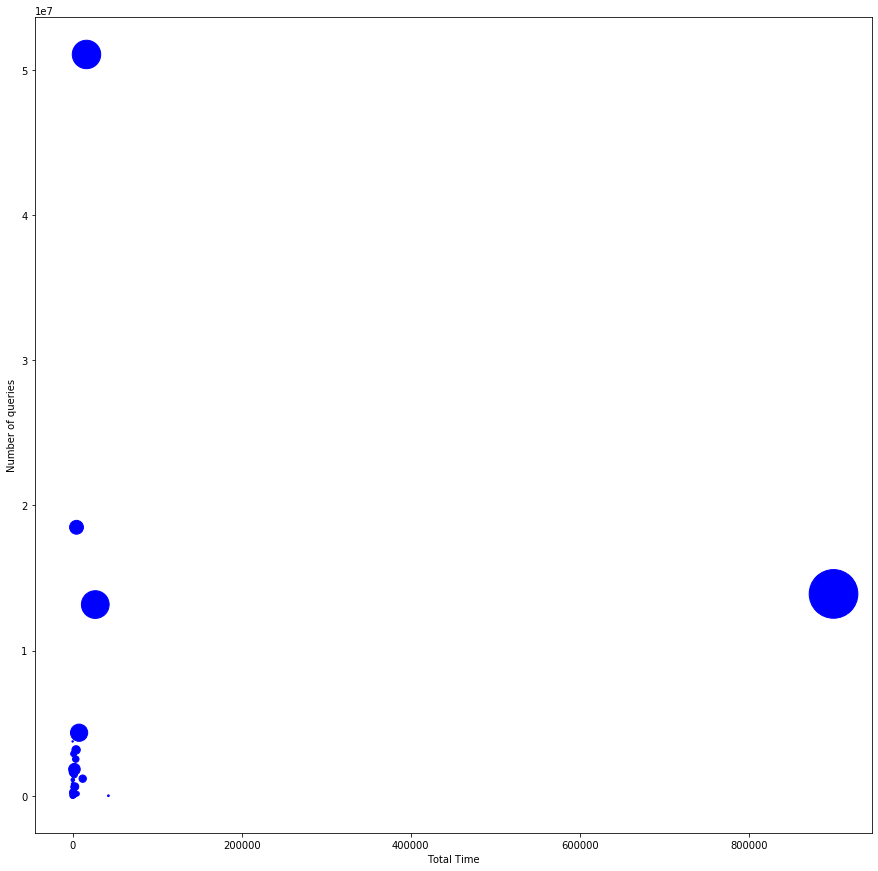

In [45]:
# Develop two scatterplots for the dashboard data set. 
# 3a.  X axis: Total Time.  Y axis: Number of queries.   Scale the size of the points to the number of sessions. 
# 3b.  X axis: base 10 log(Total Time),  Y axis: base 10 log( Number of queries).  
# Scale the size of the points to the number of sessions. 

# 3a
fig = plt.figure(figsize=(15,15))
ax = plt.axes()

ax.scatter(df['Total Time'], df['Number of queries'], s=df['Number of sessions'], color = 'blue')
plt.xlabel('Total Time')
plt.ylabel('Number of queries')
plt.show()

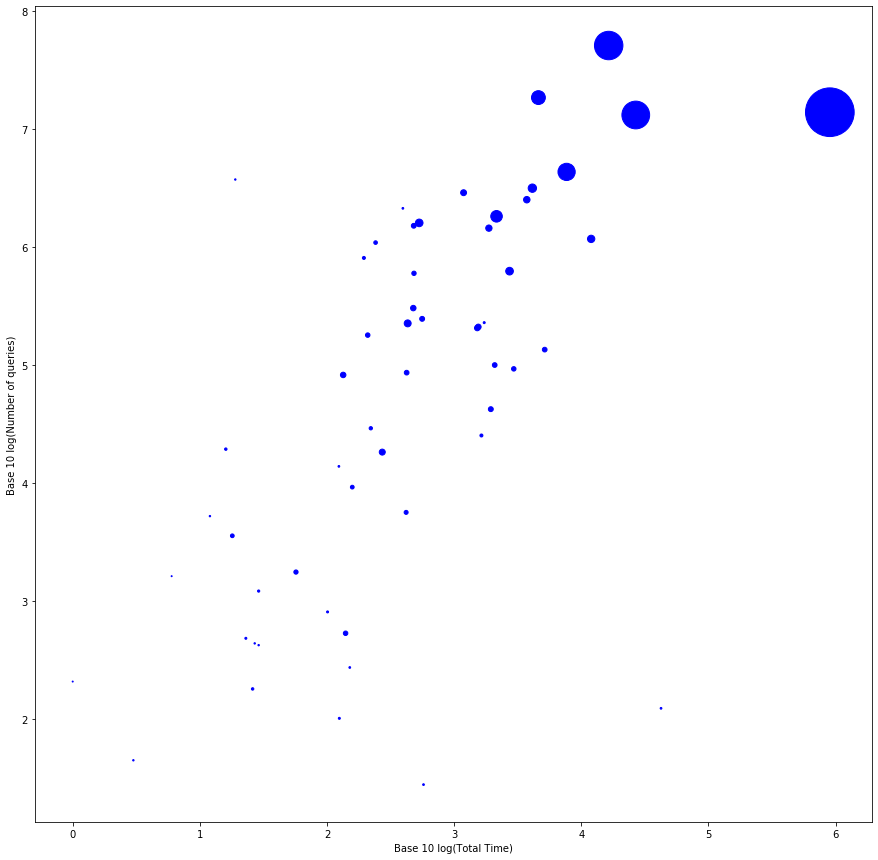

In [46]:
# 3b
fig = plt.figure(figsize=(15,15))
ax = plt.axes()

ax.scatter(np.log10(df['Total Time']), np.log10(df['Number of queries']), s=df['Number of sessions'], color = 'blue')
plt.xlabel('Base 10 log(Total Time)')
plt.ylabel('Base 10 log(Number of queries)')
plt.show()

#### OBIEE_USAGE_DETAIL_201905.xlsx

In [47]:
df2_05 = df2_05.drop('Query Text', 1)
df2_05 = df2_05.drop('Logical Query Complete Timestamp', 1)

# change the column to month 
df2_05['Logical Query Submit Timestamp'] = df2_05['Logical Query Submit Timestamp'].apply(lambda x: "05/01")
df2_05 = df2_05.rename(columns={"Logical Query Submit Timestamp": "Month"})

# Manipulate the column 'BI Path' to prep for the count 
df2_05['BI Path'] = df2_05['BI Path'].fillna("")
df2_05['Dashboard'] = df2_05['BI Path'].apply(lambda x: x.split('/')[5] if len(x.split('/')) > 5 else "unspecified")

# Count the number of unique dashboards
df_num_unique_dashboard = df2_05.groupby("Dashboard")['User'].nunique()

# Number of sessions: # of unique SESSION_ID per unique dashboard 
df_num_sessions = df2_05.groupby("Dashboard").SESSION_ID.nunique()

# Number of queries: "DB Row Return" column, add up the rows for each dashboard 
df_num_queries = df2_05.groupby("Dashboard")['DB Row Return'].sum()

# Total Time 
df_total_time = df2_05.groupby("Dashboard")['Total BI Response (sec)'].sum()

# Manipulate the original dataframe, reduce the rows to one row per unique dashboard 
df2_05 = df2_05.drop_duplicates(subset=['Dashboard'])

df2_05 = pd.merge(df2_05, df_total_time, on=['Dashboard'])
df2_05 = pd.merge(df2_05,  df_num_queries, on=['Dashboard'])
df2_05 = pd.merge(df2_05,  df_num_sessions, on=['Dashboard'])
df2_05 = pd.merge(df2_05,  df_num_unique_dashboard, on=['Dashboard'])

# drop the columns that we don't want 
df2_05 = df2_05.drop('User Campus', 1)
df2_05 = df2_05.drop('BI Path', 1)
df2_05 = df2_05.drop('BI Presentation Catalog', 1)
df2_05 = df2_05.drop('SESSION_ID_x', 1)
df2_05 = df2_05.drop('Query Rows Returned', 1)
df2_05 = df2_05.drop('DB Row Return_x',1)
df2_05 = df2_05.drop('Total BI Response (sec)_x',1)

# rename the column, and calculating the average queries per session and average time per session 
df2_05.rename(columns={'Total BI Response (sec)_y':'Total Time',
                          'DB Row Return_y':'Number of queries',
                          'SESSION_ID_y':'Number of sessions',
                          'User_y': 'Number of unique users',
                          'BI Path': 'Dashboard'}, 
                 inplace=True)

# Average queries per session: number of queries / number of sessions 
# avg time per session: number of sessions / total time 
df2_05['Avg queries per session'] = df2_05['Number of queries'] / df2_05['Number of sessions']
df2_05['Avg time per session'] = df2_05['Total Time'] / df2_05['Number of sessions'] 

# Compute additional averages for the dashboard tables: 
# avg time per unique user 
# avg queries per unique user
# avg sessions per unique user
df2_05['Avg time per unique user'] = df2_05['Total Time'] / (df2_05['User_x'].nunique())
df2_05['Avg queries per unique user'] = df2_05['Number of queries'] / (df2_05['User_x'].nunique())
df2_05['Avg sessions per unique user'] = df2_05['Number of sessions'] / (df2_05['User_x'].nunique())

df2_05 = df2_05.round({'Avg queries per session': 2, 'Avg time per session': 2,
                      'Avg time per unique user': 2, 'Avg queries per unique user': 2,
                      'Avg sessions per unique user': 2})
df2_05 = df2_05.drop('User_x', 1)
df = df2_05.replace([np.inf], np.nan)
df

Month                                          Dashboard  Total Time  \
0   05/01                                        unspecified      948771   
1   05/01                    UWHRS - HRS Transactions Report         394   
2   05/01                              UWHRS - Salary Equity       10095   
3   05/01                 UWHRS - Current Employees and Jobs       21437   
4   05/01                                UWHRS - Job History       56880   
5   05/01                   UWHRS - Leave Usage and Balances        7255   
6   05/01                                 UWHRS - Ended Jobs         244   
7   05/01                                UWHRS - Leave Taken         877   
8   05/01                                  UWHRS - Diversity         550   
9   05/01                  UWHRS - Rehired Annuitants Report         343   
10  05/01                              UWHRS - Job Probation          19   
11  05/01                  UWHRS - Supervisors and Approvers        2443   
12  05/01            UWHRS - Rate and Jobcode History Report        3177   
13  05/01               UWHRS - Hires for a Given Date Range          54   
14  05/01                  UWHRS - Criminal Background Check        1179   
15  05/01              UWHRS - Payroll and Deduction History        7384   
16  05/01                      UWHRS - Biweekly Payroll Edit        5323   
17  05/01                  UWHRS - ACA Student Hours Over 25        3757   
18  05/01                UWHRS - International Student Hours         397   
19  05/01                      UWHRS - Employees Without ACH           9   
20  05/01                 UWHRS - Monthly Payroll Checksheet         172   
21  05/01                  UWHRS - Time Approver Information        4907   
22  05/01                         UWHRS - AS Time in Jobcode         119   
23  05/01                        UWHRS - AS Years in Service         110   
24  05/01                UWHRS - Employees Termed Five Years          52   
25  05/01                           UWHRS - Employment Visas        2561   
26  05/01                        UWHRS - Faculty Sabbaticals         202   
27  05/01       UWHRS - First Hire Date and Years of Service        9600   
28  05/01                               UWHRS - FTE Overload         489   
29  05/01                            UWHRS - I-9 Disposition          27   
30  05/01                UWHRS - Jobs for a Given Date Range        1709   
31  05/01                             UWHRS - LTE Monitoring         201   
32  05/01                          UWHRS - Position of Trust          15   
33  05/01                              UWHRS - Retitled Jobs           7   
34  05/01                           UWHRS - Termed Employees         430   
35  05/01                UWHRS - Employee Hours and Earnings         535   
36  05/01                                           Analyses         314   
37  05/01                                  UWHRS - Directory         704   
38  05/01                        UWHRS - HRS Payroll History         664   
39  05/01                       UWHRS - Absences Information          22   
40  05/01                       UWHRS - Deduction Comparison         231   
41  05/01                          UWHRS - BiWeekly OT Hours          22   
42  05/01                           UWHRS - Employee Profile         176   
43  05/01                UWHRS - Sensitive Person & Job Data         182   
44  05/01                  UWHRS - Empl YTD Earngs-Ded-Taxes       44149   
45  05/01                        UWHRS - Retiree and Emeriti         461   
46  05/01               UWHRS - Leave Balances (Termed Jobs)         307   
47  05/01                 UWHRS - Standard vs Approved Hours         998   
48  05/01  UWHRS - Classified Carryover Vacation and Comp...           2   
49  05/01                              UWHRS - Layoff Review          18   
50  05/01          UWHRS - InfoAccess Classified Leave Usage          76   
51  05/01                   UWHRS - Tenure and Relat

In [48]:
# calculating the sum of the total time 
df['Total Time'].sum()

1148128

In [49]:
# calculating the sum of the number of queries 
df['Number of queries'].sum()

275465989

In [50]:
# Develop two scatterplots for the dashboard data set. 
# 3a.  X axis: Total Time.  Y axis: Number of queries.   Scale the size of the points to the number of sessions. 
# 3b.  X axis: base 10 log(Total Time),  Y axis: base 10 log( Number of queries).  
# Scale the size of the points to the number of sessions. 

# 3a
fig = plt.figure(figsize=(15,15))
ax = plt.axes()

ax.scatter(df['Total Time'], df['Number of queries'], s=df['Number of sessions'], color = 'blue')
plt.xlabel('Total Time')
plt.ylabel('Number of queries')
plt.show()

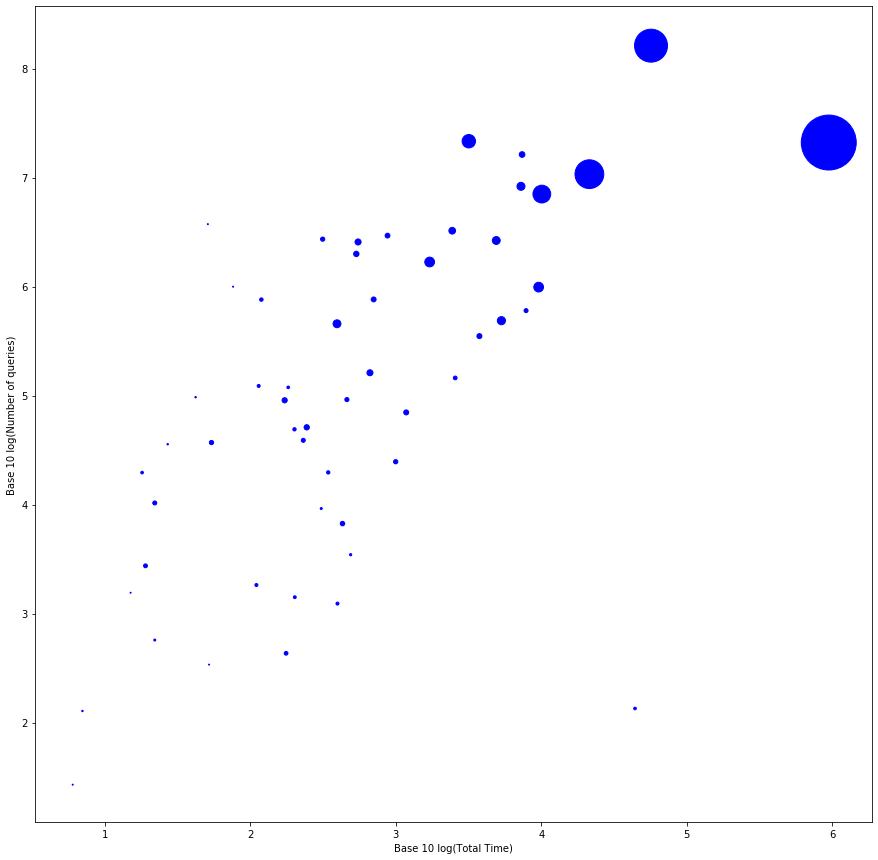

In [51]:
np.seterr(divide = 'ignore') 

# 3b
fig = plt.figure(figsize=(15,15))
ax = plt.axes()

ax.scatter(np.log10(df['Total Time']), np.log10(df['Number of queries']), s=df['Number of sessions'], color = 'blue')
plt.xlabel('Base 10 log(Total Time)')
plt.ylabel('Base 10 log(Number of queries)')
plt.show()

#### OBIEE_USAGE_DETAIL_201906.xlsx

In [52]:
df3_06 = df3_06.drop('Query Text', 1)
df3_06 = df3_06.drop('Logical Query Complete Timestamp', 1)

# change the column to month 
df3_06['Logical Query Submit Timestamp'] = df3_06['Logical Query Submit Timestamp'].apply(lambda x: "06/01")
df3_06 = df3_06.rename(columns={"Logical Query Submit Timestamp": "Month"})

# Manipulate the column 'BI Path' to prep for the count 

# fill the blank row with ""(empty string)
df3_06['BI Path'] = df3_06['BI Path'].fillna("")
# create a new column. If the user has dashboard specified, put the dashboard name in this column. Else, put 'Unspecified'
df3_06['Dashboard'] = df3_06['BI Path'].apply(lambda x: x.split('/')[5] if len(x.split('/')) > 5 else "Unspecified")

# Count the number of unique dashboards
df_num_unique_dashboard = df3_06.groupby("Dashboard")['User'].nunique()

# Number of sessions: # of unique SESSION_ID per unique dashboard 
df_num_sessions = df3_06.groupby("Dashboard").SESSION_ID.nunique()

# Number of queries: "DB Row Return" column, add up the rows for each dashboard 
df_num_queries = df3_06.groupby("Dashboard")['DB Row Return'].sum()

# Total Time 
df_total_time = df3_06.groupby("Dashboard")['Total BI Response (sec)'].sum()

# Manipulate the original dataframe, reduce the rows to one row per unique dashboard 
df3_06 = df3_06.drop_duplicates(subset=['Dashboard'])

df3_06 = pd.merge(df3_06, df_total_time, on=['Dashboard'])
df3_06 = pd.merge(df3_06,  df_num_queries, on=['Dashboard'])
df3_06 = pd.merge(df3_06,  df_num_sessions, on=['Dashboard'])
df3_06 = pd.merge(df3_06,  df_num_unique_dashboard, on=['Dashboard'])

# drop the columns that we don't want 
df3_06 = df3_06.drop('User Campus', 1)
df3_06 = df3_06.drop('BI Path', 1)
df3_06 = df3_06.drop('BI Presentation Catalog', 1)
df3_06 = df3_06.drop('SESSION_ID_x', 1)
df3_06 = df3_06.drop('Query Rows Returned', 1)
df3_06 = df3_06.drop('DB Row Return_x',1)
df3_06 = df3_06.drop('Total BI Response (sec)_x',1)

# rename the column, and calculating the average queries per session and average time per session 
df3_06.rename(columns={'Total BI Response (sec)_y':'Total Time',
                          'DB Row Return_y':'Number of queries',
                          'SESSION_ID_y':'Number of sessions',
                          'User_y': 'Number of unique users',
                          'BI Path': 'Dashboard'}, 
                 inplace=True)

# Average queries per session: number of queries / number of sessions 
# avg time per session: number of sessions / total time 
df3_06['Avg queries per session'] = df3_06['Number of queries'] / df3_06['Number of sessions']
df3_06['Avg time per session'] = df3_06['Total Time'] / df3_06['Number of sessions'] 

# Compute additional averages for the dashboard tables: 
# avg time per unique user 
# avg queries per unique user
# avg sessions per unique user
df3_06['Avg time per unique user'] = df3_06['Total Time'] / (df3_06['User_x'].nunique())
df3_06['Avg queries per unique user'] = df3_06['Number of queries'] / (df3_06['User_x'].nunique())
df3_06['Avg sessions per unique user'] = df3_06['Number of sessions'] / (df3_06['User_x'].nunique())

df3_06 = df3_06.round({'Avg queries per session': 2, 'Avg time per session': 2,
                      'Avg time per unique user': 2, 'Avg queries per unique user': 2,
                      'Avg sessions per unique user': 2})
df3_06 = df3_06.drop('User_x', 1)

df = df3_06.replace([np.inf], np.nan)
df

Month                                          Dashboard  Total Time  \
0   06/01                 UWHRS - Current Employees and Jobs       15955   
1   06/01                                        Unspecified      688414   
2   06/01                                UWHRS - Job History       21092   
3   06/01                              UWHRS - Salary Equity        7211   
4   06/01                           UWHRS - Employee Profile         108   
5   06/01                   UWHRS - Leave Usage and Balances        3449   
6   06/01                       UWHRS - Absences Information          43   
7   06/01              UWHRS - Payroll and Deduction History        3304   
8   06/01                        UWHRS - HRS Payroll History         791   
9   06/01                                UWHRS - Leave Taken        1099   
10  06/01                                 UWHRS - Ended Jobs         527   
11  06/01                UWHRS - Sensitive Person & Job Data         100   
12  06/01               UWHRS - Hires for a Given Date Range          40   
13  06/01                                  UWHRS - Diversity         613   
14  06/01                UWHRS - Jobs for a Given Date Range        1016   
15  06/01                              UWHRS - Job Probation           6   
16  06/01                  UWHRS - Criminal Background Check         324   
17  06/01                  UWHRS - Supervisors and Approvers        1045   
18  06/01                    UWHRS - HRS Transactions Report         279   
19  06/01                      UWHRS - Biweekly Payroll Edit        5645   
20  06/01                 UWHRS - Monthly Payroll Checksheet        1600   
21  06/01                  UWHRS - Time Approver Information         870   
22  06/01                        UWHRS - AS Years in Service         649   
23  06/01       UWHRS - First Hire Date and Years of Service       13292   
24  06/01                             UWHRS - LTE Monitoring         225   
25  06/01            UWHRS - Rate and Jobcode History Report        3079   
26  06/01                                  UWHRS - Directory         466   
27  06/01                           UWHRS - Termed Employees        1161   
28  06/01                       UWHRS - Deduction Comparison         258   
29  06/01                UWHRS - International Student Hours         218   
..    ...                                                ...         ...   
36  06/01                    UWLAC - PO Balances POE and POL           1   
37  06/01                         UWHRS - AS Time in Jobcode          46   
38  06/01                        UWHRS - Retiree and Emeriti          15   
39  06/01                   UWHRS - Tenure and Relationships          40   
40  06/01                UWHRS - Employee Hours and Earnings         439   
41  06/01  UWHRS - InfoAccess Unclassified Leave Data-Act...          89   
42  06/01  UWHRS - Classified Carryover Vacation and Comp...           3   
43  06/01                          UWHRS - BiWeekly OT Hours          57   
44  06/01                 UWHRS - Standard vs Approved Hours         646   
45  06/01                UWHRS - Employees Termed Five Years         262   
46  06/01                  UWHRS - ACA Student Hours Over 25        5122   
47  06/01                         UWHRS - Person of Interest           0   
48  06/01                              UWHRS - Layoff Review          22   
49  06/01      UWHRS - Workstudy Award Job and Earnings Info         101   
50  06/01                  UWHRS - Rehired Annuitants Report         314   
51  06/01                           UWHRS - Career Positions          16   
52  06/01               UWHRS - Leave Balances (Termed Jobs)           2   
53  06/01                              UWHRS - Jobs on Leave         861   
54  06/01                        UWHRS - Faculty Sabbaticals         107   
55  06/01                                 UWBI Usage - UWHRS           1   
56  06/01                                 UWBI Usage

In [53]:
# calculating the sum of the total time 
df['Total Time'].sum()

785815

In [54]:
# calculating the sum of the number of queries 
df['Number of queries'].sum()

-2751981857

In [55]:
# Develop two scatterplots for the dashboard data set. 
# 3a.  X axis: Total Time.  Y axis: Number of queries.   Scale the size of the points to the number of sessions. 
# 3b.  X axis: base 10 log(Total Time),  Y axis: base 10 log( Number of queries).  
# Scale the size of the points to the number of sessions. 

# 3a
fig = plt.figure(figsize=(15,15))
ax = plt.axes()

ax.scatter(df['Total Time'], df['Number of queries'], s=df['Number of sessions'], color = 'blue')
plt.xlabel('Total Time')
plt.ylabel('Number of queries')
plt.show()

C:\Users\sliu\.conda\envs\test\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys


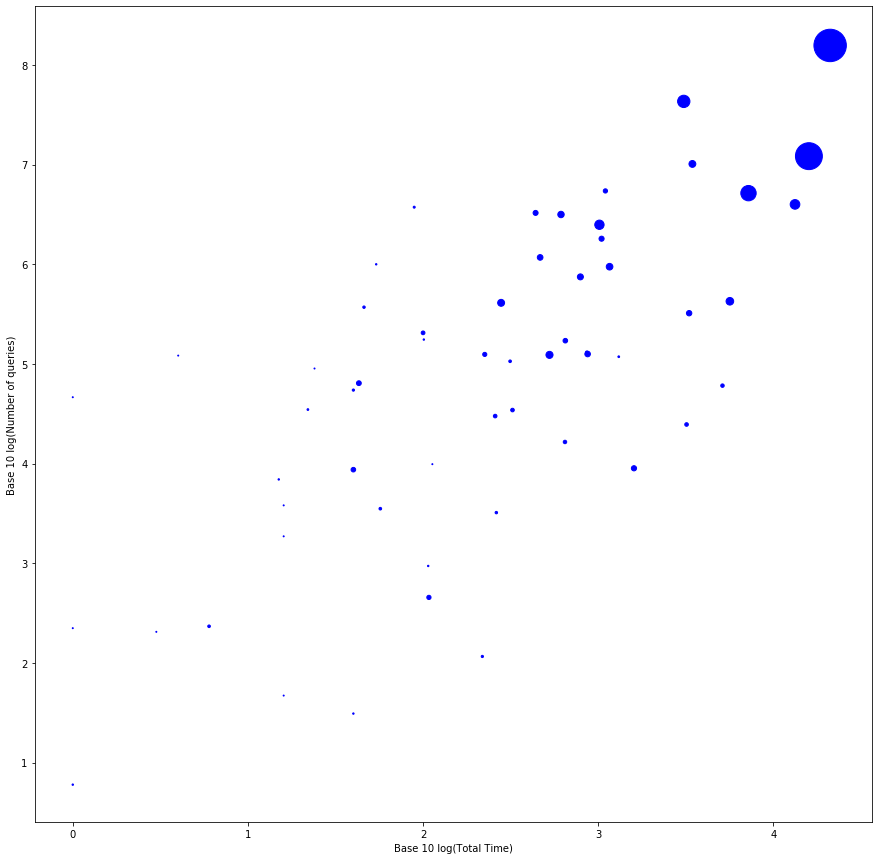

In [56]:
np.seterr(divide = 'ignore') 
# problem: invalid value encountered in log10 
# Guesses: encounter with negative values 

# 3b
fig = plt.figure(figsize=(15,15))
ax = plt.axes()

ax.scatter(np.log10(df['Total Time']), np.log10(df['Number of queries']), s=df['Number of sessions'], color = 'blue')
plt.xlabel('Base 10 log(Total Time)')
plt.ylabel('Base 10 log(Number of queries)')
plt.show()

### User/Dashboard Report 

Element: Month, User, Catalog, Dashboard, # sessions, # queries, total time, average queries per session, avg time per session 

* Month: Get from "Logical Query Submit/Complete Timestamp" column (Start date of the month)


* Catalog: The fourth element 


* Dashboard: Get from "BI path" column. The fifth element. If there's no fifth element, leave it as "unspecified". Blank is left as blank. 

Example: /shared/UWSYS - Shared/UWHRS - Shared/UWHRS - Compensation Reports/UWHRS - Salary Equity/Analyses/Salary Statistics Overview (UWHRS-Salary Equity)


* User: Get from "User" column


* number of sessions: number of unique SESSION_ID per unique user & dashboard 


* number of queries: Get from "DB Row Return" column, add up the columns for each individual unique user & dashboard 


* total time: Total BI Response (sec) per unique user & dashboard 


* Average queries per session: # of queries / # of sessions 


* avg time per session: # of sessions / total time 

In [57]:
# Read the Excel table again into pandas Dataframes 
df1_04 = pd.read_excel("OBIEE_USAGE_DETAIL_201904.xlsx")
df2_05 = pd.read_excel("OBIEE_USAGE_DETAIL_201905.xlsx")
df3_06 = pd.read_excel("OBIEE_USAGE_DETAIL_201906.xlsx")

directly use the df1_04, df2_05, and df3_06 dataframes before 
#### OBIEE_USAGE_DETAIL_201904.xlsx

In [58]:
# change the column to month 
df1_04 = df1_04.drop('Query Text', 1)
df1_04 = df1_04.drop('Logical Query Complete Timestamp', 1)
df1_04['Logical Query Submit Timestamp'] = df1_04['Logical Query Submit Timestamp'].apply(lambda x: "04/01")
df1_04 = df1_04.rename(columns={"Logical Query Submit Timestamp": "Month"})


# Catalog 
df1_04['BI Path'] = df1_04['BI Path'].fillna("")

# Manipulate the column 'BI Path' to prep for catolog  
df1_04['Catalog'] = df1_04['BI Path'].apply(lambda x: x.split('/')[4] if len(x.split('/')) > 4 else "Unspecified")
df1_04['Dashboard'] = df1_04['BI Path'].apply(lambda x: x.split('/')[5] if len(x.split('/')) > 5 else "Unspecified")

In [59]:
# number of sessions 

# make a new column (combo: User + Dashboard )
pd.options.mode.chained_assignment = None  # default='warn'
df1_04['temp'] = df1_04['User'].astype(str) + df1_04['Dashboard'].astype(str)

# number of sessions: # of unique SESSION_ID per unique 
df_num_sessions = df1_04.groupby("temp").SESSION_ID.nunique()

# number of queries 
df_num_queries = df1_04.groupby("temp")['DB Row Return'].sum()

# Total Time 
df_total_time = df1_04.groupby("temp")['Total BI Response (sec)'].sum()

In [60]:
# Manipulate the original dataframe, reduce the rows to one row per unique user/dashboard 
df1_04 = df1_04.drop_duplicates(subset=['temp'])

In [61]:
df1_04 = pd.merge(df1_04, df_total_time, on=['temp'])
df1_04 = pd.merge(df1_04,  df_num_queries, on=['temp'])
df1_04 = pd.merge(df1_04,  df_num_sessions, on=['temp'])

In [62]:
# drop the columns that we don't want 
df1_04 = df1_04.drop('User Campus', 1)
df1_04 = df1_04.drop('BI Presentation Catalog', 1)
df1_04 = df1_04.drop('SESSION_ID_x', 1)
df1_04 = df1_04.drop('Query Rows Returned', 1)
df1_04 = df1_04.drop('DB Row Return_x',1)
df1_04 = df1_04.drop('Total BI Response (sec)_x',1)
df1_04 = df1_04.drop('temp',1)
df1_04 = df1_04.drop('BI Path',1)

In [63]:
# rename the column, and calculating the average queries per session and average time per session 
df1_04.rename(columns={'Total BI Response (sec)_y':'Total Time',
                          'DB Row Return_y':'Number of queries',
                          'SESSION_ID_y':'Number of sessions'}, 
                 inplace=True)

In [64]:
# Average queries per session: number of queries / number of sessions 
# avg time per session: number of sessions / total time 
df1_04['Avg queries per session'] = df1_04['Number of queries'] / df1_04['Number of sessions']
df1_04['Avg time per session'] =  df1_04['Total Time'] / df1_04['Number of sessions'] 

df1_04 = df1_04.round({'Avg queries per session': 2, 'Avg time per session': 2})

# replace the inf value (because the total time = 0) with NaN
df = df1_04.replace([np.inf], np.nan)
df

User  Month                              Catalog  \
0       aaarnold@wisc.edu  04/01                          Unspecified   
1       aaarnold@wisc.edu  04/01         UWHRS - Compensation Reports   
2       aaarnold@wisc.edu  04/01            UWHRS - Workforce Reports   
3       aaarnold@wisc.edu  04/01            UWHRS - Workforce Reports   
4       aaarnold@wisc.edu  04/01            UWHRS - Workforce Reports   
5      abradshaw@wisc.edu  04/01                          Unspecified   
6      abradshaw@wisc.edu  04/01  UWHRS - Absence and Accrual Reports   
7      abradshaw@wisc.edu  04/01              UWHRS - Payroll Reports   
8      abradshaw@wisc.edu  04/01              UWHRS - Payroll Reports   
9      abradshaw@wisc.edu  04/01  UWHRS - Absence and Accrual Reports   
10     abradshaw@wisc.edu  04/01       UWHRS - Time and Labor Reports   
11     abradshaw@wisc.edu  04/01            UWHRS - Workforce Reports   
12     abradshaw@wisc.edu  04/01            UWHRS - Workforce Reports   
13     abradshaw@wisc.edu  04/01            UWHRS - Workforce Reports   
14     abradshaw@wisc.edu  04/01         UWHRS - Demographics Reports   
15     ackinney2@wisc.edu  04/01                          Unspecified   
16     ackinney2@wisc.edu  04/01  UWHRS - Absence and Accrual Reports   
17     ackinney2@wisc.edu  04/01            UWHRS - Workforce Reports   
18     ackinney2@wisc.edu  04/01            UWHRS - Workforce Reports   
19     ackinney2@wisc.edu  04/01         UWHRS - Demographics Reports   
20     ackinney2@wisc.edu  04/01            UWHRS - Workforce Reports   
21     ackinney2@wisc.edu  04/01            UWHRS - Workforce Reports   
22     ackinney2@wisc.edu  04/01            UWHRS - Workforce Reports   
23     ackinney2@wisc.edu  04/01            UWHRS - Workforce Reports   
24     ackinney2@wisc.edu  04/01            UWHRS - Workforce Reports   
25      acmalone@wisc.edu  04/01                          Unspecified   
26      acmalone@wisc.edu  04/01       UWHRS - Time and Labor Reports   
27      acmalone@wisc.edu  04/01            UWHRS - Workforce Reports   
28      acmalone@wisc.edu  04/01              UWHRS - Payroll Reports   
29      acmalone@wisc.edu  04/01       UWHRS - Time and Labor Reports   
...                   ...    ...                                  ...   
1293     vlkelly@wisc.edu  04/01            UWHRS - Workforce Reports   
1294     vlkelly@wisc.edu  04/01            UWHRS - Workforce Reports   
1295     vlkelly@wisc.edu  04/01            UWHRS - Workforce Reports   
1296    vpierce2@wisc.edu  04/01                          Unspecified   
1297    vpierce2@wisc.edu  04/01            UWHRS - Workforce Reports   
1298    vpierce2@wisc.edu  04/01            UWHRS - Workforce Reports   
1299    vpierce2@wisc.edu  04/01            UWHRS - Workforce Reports   
1300     vtimler@wisc.edu  04/01                          Unspecified   
1301     vtimler@wisc.edu  04/01  UWHRS - Absence and Accrual Reports   
1302     vtimler@wisc.edu  04/01         UWHRS - Compensation Reports   
1303     vtimler@wisc.edu  04/01            UWHRS - Workforce Reports   
1304     vtimler@wisc.edu  04/01            UWHRS - Workforce Reports   
1305     vtimler@wisc.edu  04/01            UWHRS - Workforce Reports   
1306      vvosen@wisc.edu  04/01                          Unspecified   
1307      vvosen@wisc.edu  04/01            UWHRS - Workforce Reports   
1308      vvosen@wisc.edu  04/01            UWHRS - Workforce Reports   
1309      vvosen@wisc.edu  04/01            UWHRS - Workforce Reports   
1310  wbollinger@wisc.edu  04/01                          Unspecified   
1311  wbollinger@wisc.edu  04/01            UWHRS - Workforce Reports   
1312      wemett@wisc.edu  04/01                          Unspecified   
1313      wemett@wisc.edu  04/01       UWHRS - Time and Labor Reports   
1314      wemett@wisc.edu  04/01            UWHRS - Workforce Reports   
1315     zickuhr@wisc.edu  04/01                          Unspecified   
1316  

In [65]:
# calculating the sum of the total time 
df['Total Time'].sum()

1052091

In [66]:
# calculating the sum of the number of queries 
df['Number of queries'].sum()

128628585

#### OBIEE_USAGE_DETAIL_201905.xlsx

In [67]:
# change the column to month 
df2_05 = df2_05.drop('Query Text', 1)
df2_05 = df2_05.drop('Logical Query Complete Timestamp', 1)
df2_05['Logical Query Submit Timestamp'] = df2_05['Logical Query Submit Timestamp'].apply(lambda x: "05/01")
df2_05 = df2_05.rename(columns={"Logical Query Submit Timestamp": "Month"})


# Catalog 
df2_05['BI Path'] = df2_05['BI Path'].fillna("")

# Manipulate the column 'BI Path' to prep for catolog  
df2_05['Catalog'] = df2_05['BI Path'].apply(lambda x: x.split('/')[4] if len(x.split('/')) > 4 else "Unspecified")
df2_05['Dashboard'] = df2_05['BI Path'].apply(lambda x: x.split('/')[5] if len(x.split('/')) > 5 else "Unspecified")

# number of sessions 

# make a new column (combo: User + Dashboard )
pd.options.mode.chained_assignment = None  # default='warn'
df2_05['temp'] = df2_05['User'].astype(str) + df2_05['Dashboard'].astype(str)

# number of sessions: # of unique SESSION_ID per unique 
df_num_sessions = df2_05.groupby("temp").SESSION_ID.nunique()

# number of queries 
df_num_queries = df2_05.groupby("temp")['DB Row Return'].sum()

# Total Time 
df_total_time = df2_05.groupby("temp")['Total BI Response (sec)'].sum()

# Manipulate the original dataframe, reduce the rows to one row per unique user/dashboard 
df2_05 = df2_05.drop_duplicates(subset=['temp'])

df2_05 = pd.merge(df2_05, df_total_time, on=['temp'])
df2_05 = pd.merge(df2_05,  df_num_queries, on=['temp'])
df2_05 = pd.merge(df2_05,  df_num_sessions, on=['temp'])

# drop the columns that we don't want 
df2_05 = df2_05.drop('User Campus', 1)
df2_05 = df2_05.drop('BI Presentation Catalog', 1)
df2_05 = df2_05.drop('SESSION_ID_x', 1)
df2_05 = df2_05.drop('Query Rows Returned', 1)
df2_05 = df2_05.drop('DB Row Return_x',1)
df2_05 = df2_05.drop('Total BI Response (sec)_x',1)
df2_05 = df2_05.drop('temp',1)
df2_05 = df2_05.drop('BI Path',1)

# rename the column, and calculating the average queries per session and average time per session 
df2_05.rename(columns={'Total BI Response (sec)_y':'Total Time',
                          'DB Row Return_y':'Number of queries',
                          'SESSION_ID_y':'Number of sessions'}, 
                 inplace=True)

# Average queries per session: number of queries / number of sessions 
# avg time per session: number of sessions / total time 
df2_05['Avg queries per session'] = df2_05['Number of queries'] / df2_05['Number of sessions']
df2_05['Avg time per session'] =  df2_05['Total Time'] / df2_05['Number of sessions'] 

df2_05 = df2_05.round({'Avg queries per session': 2, 'Avg time per session': 2})

# replace the inf value (because the total time = 0) with NaN
df = df2_05.replace([np.inf], np.nan)
df

User  Month                              Catalog  \
0       aaarnold@wisc.edu  05/01                          Unspecified   
1       aaarnold@wisc.edu  05/01            UWHRS - Workforce Reports   
2       aaarnold@wisc.edu  05/01         UWHRS - Compensation Reports   
3       aaarnold@wisc.edu  05/01            UWHRS - Workforce Reports   
4       aaarnold@wisc.edu  05/01            UWHRS - Workforce Reports   
5        aahearn@wisc.edu  05/01                          Unspecified   
6        aahearn@wisc.edu  05/01  UWHRS - Absence and Accrual Reports   
7        aahearn@wisc.edu  05/01            UWHRS - Workforce Reports   
8      abradshaw@wisc.edu  05/01                          Unspecified   
9      abradshaw@wisc.edu  05/01            UWHRS - Workforce Reports   
10     abradshaw@wisc.edu  05/01            UWHRS - Workforce Reports   
11     ackinney2@wisc.edu  05/01                          Unspecified   
12     ackinney2@wisc.edu  05/01  UWHRS - Absence and Accrual Reports   
13     ackinney2@wisc.edu  05/01  UWHRS - Absence and Accrual Reports   
14     ackinney2@wisc.edu  05/01         UWHRS - Demographics Reports   
15     ackinney2@wisc.edu  05/01            UWHRS - Workforce Reports   
16     ackinney2@wisc.edu  05/01            UWHRS - Workforce Reports   
17     ackinney2@wisc.edu  05/01            UWHRS - Workforce Reports   
18     ackinney2@wisc.edu  05/01            UWHRS - Workforce Reports   
19     ackinney2@wisc.edu  05/01            UWHRS - Workforce Reports   
20     ackinney2@wisc.edu  05/01            UWHRS - Workforce Reports   
21     ackinney2@wisc.edu  05/01            UWHRS - Workforce Reports   
22     ackinney2@wisc.edu  05/01            UWHRS - Workforce Reports   
23     ackinney2@wisc.edu  05/01            UWHRS - Workforce Reports   
24     ackinney2@wisc.edu  05/01            UWHRS - Workforce Reports   
25      acmalone@wisc.edu  05/01                          Unspecified   
26      acmalone@wisc.edu  05/01              UWHRS - Payroll Reports   
27      acmalone@wisc.edu  05/01       UWHRS - Time and Labor Reports   
28      acmalone@wisc.edu  05/01            UWHRS - Workforce Reports   
29      acmalone@wisc.edu  05/01            UWHRS - Workforce Reports   
...                   ...    ...                                  ...   
1291     vtimler@wisc.edu  05/01            UWHRS - Workforce Reports   
1292      vvosen@wisc.edu  05/01            UWHRS - Workforce Reports   
1293      vvosen@wisc.edu  05/01                          Unspecified   
1294      vvosen@wisc.edu  05/01         UWHRS - Demographics Reports   
1295      vvosen@wisc.edu  05/01            UWHRS - Workforce Reports   
1296      vvosen@wisc.edu  05/01            UWHRS - Workforce Reports   
1297      vvosen@wisc.edu  05/01            UWHRS - Workforce Reports   
1298  wbollinger@wisc.edu  05/01                          Unspecified   
1299  wbollinger@wisc.edu  05/01              UWHRS - Payroll Reports   
1300  wbollinger@wisc.edu  05/01       UWHRS - Time and Labor Reports   
1301  wbollinger@wisc.edu  05/01            UWHRS - Workforce Reports   
1302  wbollinger@wisc.edu  05/01            UWHRS - Workforce Reports   
1303  wbollinger@wisc.edu  05/01            UWHRS - Workforce Reports   
1304      wemett@wisc.edu  05/01                          Unspecified   
1305      wemett@wisc.edu  05/01       UWHRS - Time and Labor Reports   
1306      wemett@wisc.edu  05/01              UWHRS - Payroll Reports   
1307      wemett@wisc.edu  05/01            UWHRS - Workforce Reports   
1308     whetter@wisc.edu  05/01                          Unspecified   
1309     whetter@wisc.edu  05/01            UWHRS - Workforce Reports   
1310     whetter@wisc.edu  05/01            UWHRS - Workforce Reports   
1311       wild2@wisc.edu  05/01                          Unspecified   
1312       wild2@wisc.edu  05/01              UWHRS - Payroll Reports   
1313     zickuhr@wisc.edu  05/01                          Unspecified   
1314  

In [68]:
# calculating the sum of the total time 
df['Total Time'].sum()

1148128

In [69]:
# calculating the sum of the number of queries 
df['Number of queries'].sum()

275465989

#### OBIEE_USAGE_DETAIL_201906.xlsx

In [70]:
# change the column to month 
df3_06 = df3_06.drop('Query Text', 1)
df3_06 = df3_06.drop('Logical Query Complete Timestamp', 1)
df3_06['Logical Query Submit Timestamp'] = df3_06['Logical Query Submit Timestamp'].apply(lambda x: "05/01")
df3_06 = df3_06.rename(columns={"Logical Query Submit Timestamp": "Month"})


# Catalog 
df3_06['BI Path'] = df3_06['BI Path'].fillna("")

# Manipulate the column 'BI Path' to prep for catolog  
df3_06['Catalog'] = df3_06['BI Path'].apply(lambda x: x.split('/')[4] if len(x.split('/')) > 4 else "Unspecified")
df3_06['Dashboard'] = df3_06['BI Path'].apply(lambda x: x.split('/')[5] if len(x.split('/')) > 5 else "Unspecified")

# number of sessions 

# make a new column (combo: User + Dashboard )
pd.options.mode.chained_assignment = None  # default='warn'
df3_06['temp'] = df3_06['User'].astype(str) + df3_06['Dashboard'].astype(str)

# number of sessions: # of unique SESSION_ID per unique 
df_num_sessions = df3_06.groupby("temp").SESSION_ID.nunique()

# number of queries 
df_num_queries = df3_06.groupby("temp")['DB Row Return'].sum()

# Total Time 
df_total_time = df3_06.groupby("temp")['Total BI Response (sec)'].sum()

# Manipulate the original dataframe, reduce the rows to one row per unique user/dashboard 
df3_06 = df3_06.drop_duplicates(subset=['temp'])

df3_06 = pd.merge(df3_06, df_total_time, on=['temp'])
df3_06 = pd.merge(df3_06,  df_num_queries, on=['temp'])
df3_06 = pd.merge(df3_06,  df_num_sessions, on=['temp'])

# drop the columns that we don't want 
df3_06 = df3_06.drop('User Campus', 1)
df3_06 = df3_06.drop('BI Presentation Catalog', 1)
df3_06 = df3_06.drop('SESSION_ID_x', 1)
df3_06 = df3_06.drop('Query Rows Returned', 1)
df3_06 = df3_06.drop('DB Row Return_x',1)
df3_06 = df3_06.drop('Total BI Response (sec)_x',1)
df3_06 = df3_06.drop('temp',1)
df3_06 = df3_06.drop('BI Path',1)

# rename the column, and calculating the average queries per session and average time per session 
df3_06.rename(columns={'Total BI Response (sec)_y':'Total Time',
                          'DB Row Return_y':'Number of queries',
                          'SESSION_ID_y':'Number of sessions'}, 
                 inplace=True)

# Average queries per session: number of queries / number of sessions 
# avg time per session: number of sessions / total time 
df3_06['Avg queries per session'] = df3_06['Number of queries'] / df3_06['Number of sessions']
df3_06['Avg time per session'] =  df3_06['Total Time'] / df3_06['Number of sessions'] 

df3_06 = df3_06.round({'Avg queries per session': 2, 'Avg time per session': 2})

# replace the inf value (because the total time = 0) with NaN
df = df3_06.replace([np.inf], np.nan)
df

User  Month                              Catalog  \
0         aaarnold@wisc.edu  05/01            UWHRS - Workforce Reports   
1         aaarnold@wisc.edu  05/01                          Unspecified   
2         aaarnold@wisc.edu  05/01            UWHRS - Workforce Reports   
3         aaarnold@wisc.edu  05/01         UWHRS - Compensation Reports   
4        abradshaw@wisc.edu  05/01                          Unspecified   
5        abradshaw@wisc.edu  05/01            UWHRS - Workforce Reports   
6        abradshaw@wisc.edu  05/01  UWHRS - Absence and Accrual Reports   
7        abradshaw@wisc.edu  05/01  UWHRS - Absence and Accrual Reports   
8        abradshaw@wisc.edu  05/01              UWHRS - Payroll Reports   
9        abradshaw@wisc.edu  05/01              UWHRS - Payroll Reports   
10       abradshaw@wisc.edu  05/01  UWHRS - Absence and Accrual Reports   
11       abradshaw@wisc.edu  05/01            UWHRS - Workforce Reports   
12       abradshaw@wisc.edu  05/01            UWHRS - Workforce Reports   
13       abradshaw@wisc.edu  05/01            UWHRS - Workforce Reports   
14       abradshaw@wisc.edu  05/01            UWHRS - Workforce Reports   
15       ackinney2@wisc.edu  05/01                          Unspecified   
16       ackinney2@wisc.edu  05/01  UWHRS - Absence and Accrual Reports   
17       ackinney2@wisc.edu  05/01            UWHRS - Workforce Reports   
18       ackinney2@wisc.edu  05/01            UWHRS - Workforce Reports   
19       ackinney2@wisc.edu  05/01         UWHRS - Demographics Reports   
20       ackinney2@wisc.edu  05/01            UWHRS - Workforce Reports   
21       ackinney2@wisc.edu  05/01            UWHRS - Workforce Reports   
22       ackinney2@wisc.edu  05/01            UWHRS - Workforce Reports   
23       ackinney2@wisc.edu  05/01            UWHRS - Workforce Reports   
24       ackinney2@wisc.edu  05/01            UWHRS - Workforce Reports   
25       ackinney2@wisc.edu  05/01            UWHRS - Workforce Reports   
26       ackinney2@wisc.edu  05/01            UWHRS - Workforce Reports   
27        acmalone@wisc.edu  05/01                          Unspecified   
28        acmalone@wisc.edu  05/01       UWHRS - Time and Labor Reports   
29        acmalone@wisc.edu  05/01              UWHRS - Payroll Reports   
...                     ...    ...                                  ...   
1287       vtimler@wisc.edu  05/01            UWHRS - Workforce Reports   
1288        vvosen@wisc.edu  05/01                          Unspecified   
1289        vvosen@wisc.edu  05/01            UWHRS - Workforce Reports   
1290        vvosen@wisc.edu  05/01            UWHRS - Workforce Reports   
1291        vvosen@wisc.edu  05/01            UWHRS - Workforce Reports   
1292        vvosen@wisc.edu  05/01            UWHRS - Workforce Reports   
1293        vvosen@wisc.edu  05/01            UWHRS - Workforce Reports   
1294        vvosen@wisc.edu  05/01            UWHRS - Workforce Reports   
1295    wbollinger@wisc.edu  05/01              UWHRS - Payroll Reports   
1296    wbollinger@wisc.edu  05/01                          Unspecified   
1297    wbollinger@wisc.edu  05/01              UWHRS - Payroll Reports   
1298    wbollinger@wisc.edu  05/01              UWHRS - Payroll Reports   
1299    wbollinger@wisc.edu  05/01            UWHRS - Workforce Reports   
1300    wbollinger@wisc.edu  05/01            UWHRS - Workforce Reports   
1301    wbollinger@wisc.edu  05/01            UWHRS - Workforce Reports   
1302        wemett@wisc.edu  05/01                          Unspecified   
1303        wemett@wisc.edu  05/01       UWHRS - Time and Labor Reports   
1304        wemett@wisc.edu  05/01            UWHRS - Workforce Reports   
1305         wild2@wisc.edu  05/01                          Unspecified   
1306         wild2@wisc.edu  05/01            UWHRS - Workforce Reports   
1307  wrightlannoy@wisc.edu  05/01                          Unspecified   
1308  wrightlannoy@wisc.edu  05/01            UW

In [71]:
# calculating the sum of the total time 
df['Total Time'].sum()

785815

In [72]:
# calculating the sum of the number of queries 
df['Number of queries'].sum()

-2751981857